In [1]:
import glob
import operator  as op
import itertools as it

import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from invisible_cities.io   .mcinfo_io     import load_mcparticles
from invisible_cities.icaro.hst_functions import shift_to_bin_centers as shift

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"] = 12

In [3]:
_colors = it.cycle(["r", "b", "m", "g", "y"])

def nlmap(*args):
    return np.array(list(map(*args)))

def display_event(event, event_no = None, fig=None):
    if fig is None:
        fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')
    plt.title("Event " + str(event_no))

    gamma_no  = 0
    colors, _ = it.tee(_colors)
    for particle_no, mcparticle in sorted(event.items()):
        ls = "-" if mcparticle.primary else ":"

        if mcparticle.name == "gamma":
            start = mcparticle.initial_vertex[:-1]
            stop  = mcparticle.  final_vertex[:-1]
            ax.plot(*zip(start, stop), color=next(colors), linestyle=ls)
            gamma_no += 1
        else:
            hits = mcparticle.hits
            x    = nlmap(op.attrgetter("X"), hits)
            y    = nlmap(op.attrgetter("Y"), hits)
            z    = nlmap(op.attrgetter("Z"), hits)
            e    = nlmap(op.attrgetter("E"), hits)
            ax.scatter(x, y, z, s=1e4*e, c="k")
            ax.text(x.mean(), y.mean(), z.mean(), f"{e.sum():.2f}")

def hist_text(data, eps=1, min_value=0):
    y, x, _ = data
    x = shift(x)
    for xi, yi in zip(x, y):
        if yi < min_value: continue
        plt.text(xi, yi + eps, "{:.2f}".format(yi), va="center", ha="center")

def print_event(event, event_no=None):
    print("---------------------")
    print("Event", event_no)
    print("---------------------")
    print()
    
    e_tot = 0
    e_aug = 0
    for particle_no, mcparticle in sorted(event.items()):
        hits     = mcparticle.hits
        nhits    = len(hits)
        ene      = sum(hit.E for hit in hits)
        dr       = mcparticle.final_vertex[:-1] - np.array([0, 0, 266.1])
        dr       = np.sqrt(np.sum(dr**2))
        momentum = np.sqrt(np.sum(mcparticle.p**2))
        e_tot   += ene
        if mcparticle.primary and mcparticle.name in ("e-", "gamma"):
            e_aug   += ene
        
        print()
        print("-> Particle no    ", particle_no)
        print("Particle type     ", mcparticle.name)
        print("Is primary        ", bool(mcparticle.primary))
        if not mcparticle.primary:
            print("Mother index      ", mcparticle.mother_indx)
            print("Created by        ", mcparticle.process    )

        print("Particle starts at", mcparticle.initial_vertex[:-1])
        print("Particle ends   at", mcparticle.final_vertex[:-1])
        print("Particle interacts", dr                , "mm")
        print("Particle momentum ", momentum     * 1e3, "keV")
        print("Particle energy   ", mcparticle.E * 1e3, "keV")
        print("Number of hits    ", nhits)
        print("Energy deposited  ", ene          * 1e3, "keV")

    print()
    print("Total energy deposited", e_tot * 1e3, "keV")
    print("Total energy auger    ", e_aug * 1e3, "keV")

def print_nonempty(data, thr = 1e-12):
    y, x, _ = data
    w = np.diff(x) / 2
    x = shift(x)
    for xi, yi, wi in zip(x, y, w):
        if yi < thr: continue
        print(f"Energy: {xi:.3f} ± {wi:.3f}  keV => {yi:.1f}")

def count_gammas(event):
    n_gammas_primary   = 0
    n_gammas_secondary = 0
    for particle_no, mcparticle in sorted(event.items()):
        if mcparticle.name == "gamma":
            if mcparticle.primary: n_gammas_primary   += 1
            else                 : n_gammas_secondary += 1

    return n_gammas_primary, n_gammas_secondary

def gamma_energy(event):
    e_gammas_primary   = []
    e_gammas_secondary = []
    for particle_no, mcparticle in sorted(event.items()):
        if mcparticle.name == "gamma":
            if mcparticle.primary: e_gammas_primary  .append(mcparticle.E * 1e3)
            else                 : e_gammas_secondary.append(mcparticle.E * 1e3)

    return e_gammas_primary, e_gammas_secondary

def get_dataframe(events):
    event_nos     = []
    ngammas       = []
    gamma_nos     = []
    gamma_enes    = []
    nelectrons    = []
    electron_enes = []
    for event_no, event in events.items():
        gamma_count = 0
        elect_count = 0
        auger_ene   = 0
        for _, particle in sorted(event.items()):
            if not particle.primary: continue
            if   particle.name == "gamma":
                gamma_count += 1
                gamma_enes.append(particle.E * 1e3)
            elif particle.name == "e-":
                elect_count += 1
                auger_ene   += sum(hit.E for hit in particle.hits) * 1e3

        nentries = max(1, gamma_count)
        event_nos    .extend([event_no]    * nentries)
        ngammas      .extend([gamma_count] * nentries)
        gamma_nos    .extend(list(range(nentries)))
        nelectrons   .extend([elect_count] * nentries)
        electron_enes.extend([auger_ene]   * nentries)
        if gamma_count == 0: gamma_enes.extend([-1] * nentries)

    print("shapes:", list(map(np.shape, (event_nos, ngammas, gamma_nos, gamma_enes, nelectrons, electron_enes))))
    return pd.DataFrame(dict(event   = event_nos,
                             ngammas = ngammas,
                             igamma  = gamma_nos,
                             Egamma  = gamma_enes,
                             nelect  = nelectrons,
                             Eelect  = electron_enes), index=event_nos)

In [4]:
path     = "/Users/Gonzalo/github/NEXTdata/MC/ECEC/v2_center/irene/output/data/*"
filename = glob.glob(path)[0]

In [5]:
mc = load_mcparticles(filename)
df = get_dataframe(mc)
df.head()

shapes: [(1899,), (1899,), (1899,), (1899,), (1899,), (1899,)]


,event,ngammas,igamma,Egamma,nelect,Eelect
0,0,2,0,30.937901,8,4.83782
0,0,2,1,27.186800,8,4.83782
1,1,2,0,27.186800,10,7.82814
1,1,2,1,27.465301,10,7.82814
2,2,2,0,27.465301,9,7.25538


Text(0, 0.5, 'Gamma 2 energy (keV)')

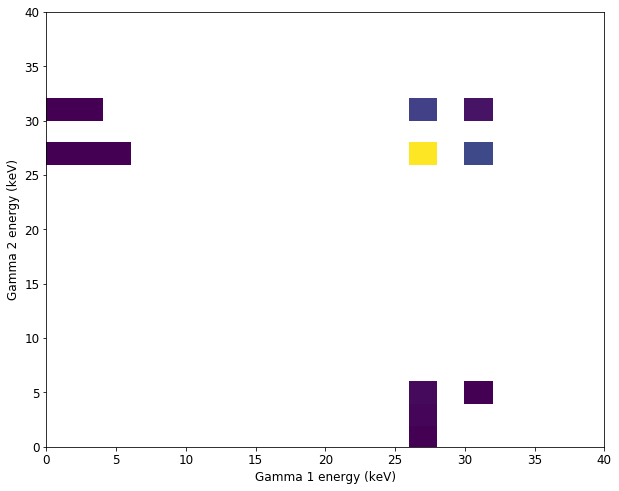

In [6]:
ebins = np.linspace(0, 40, 21)

sub = df[df.ngammas == 2]
e1  = sub.iloc[0::2].Egamma
e2  = sub.iloc[1::2].Egamma

plt.hist2d(e1, e2, (ebins, ebins), cmin=1e-10)
plt.xlabel("Gamma 1 energy (keV)")
plt.ylabel("Gamma 2 energy (keV)")

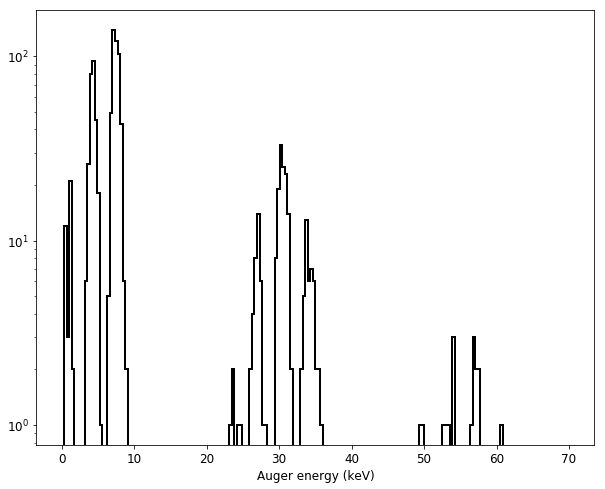

In [7]:
ebins = np.linspace(0, 70, 201)
plt.hist(df.groupby("event").Eelect.min(), ebins, histtype="step", color="k", lw=2)
plt.xlabel("Auger energy (keV)")
plt.yscale("log")

In [8]:
print_event(mc[5], 0)

---------------------
Event 0
---------------------


-> Particle no     1
Particle type      gamma
Is primary         True
Particle starts at [1.1021457e-15 0.0000000e+00 2.6610001e+02]
Particle ends   at [ -1.6420761  -0.4614659 268.21603  ]
Particle interacts 2.71789705855237 mm
Particle momentum  27.1867997944355 keV
Particle energy    27.1867997944355 keV
Number of hits     1
Energy deposited   4.774699918925762 keV

-> Particle no     2
Particle type      e-
Is primary         True
Particle starts at [1.1021457e-15 0.0000000e+00 2.6610001e+02]
Particle ends   at [1.2025376e-03 6.3795329e-04 2.6609738e+02]
Particle interacts 0.0029511256328670836 mm
Particle momentum  61.60757690668106 keV
Particle energy    3.7004000041633844 keV
Number of hits     1
Energy deposited   3.7004000041633844 keV

-> Particle no     3
Particle type      e-
Is primary         True
Particle starts at [1.1021457e-15 0.0000000e+00 2.6610001e+02]
Particle ends   at [3.60091726e-05 1.09538625e-04 2.66099945

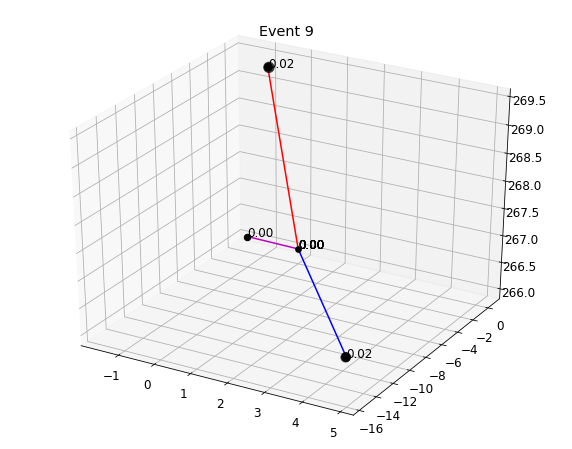

In [9]:
display_event(mc[9], 9)

In [10]:
n_p, n_s = map(np.array, zip(*map(count_gammas, mc.values())))
n_t      = n_p + n_s

w_p = np.full(n_p.size, 100/n_p.size)
w_s = np.full(n_s.size, 100/n_s.size)
w_t = np.full(n_t.size, 100/n_t.size)

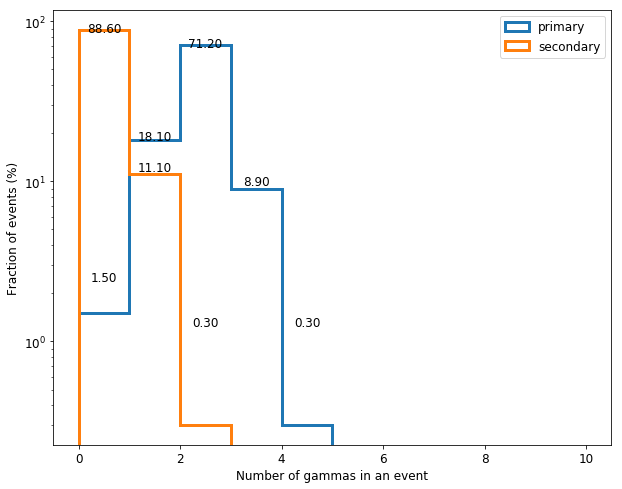

In [11]:
plt.figure()
data_p = plt.hist(n_p, np.arange(11), weights=w_p, histtype="step", lw=3, label="primary")
data_s = plt.hist(n_s, np.arange(11), weights=w_s, histtype="step", lw=3, label="secondary")
#plt.hist(n_t, np.arange(11), weights=w_s, histtype="step", lw=3, label="secondary")
hist_text(data_p, min_value= 0.25)
hist_text(data_s, min_value= 0.25)
plt.yscale("log")
plt.xlabel("Number of gammas in an event")
plt.ylabel("Fraction of events (%)")
plt.legend()

Text(0, 0.5, 'Number of secondary gammas in an event')

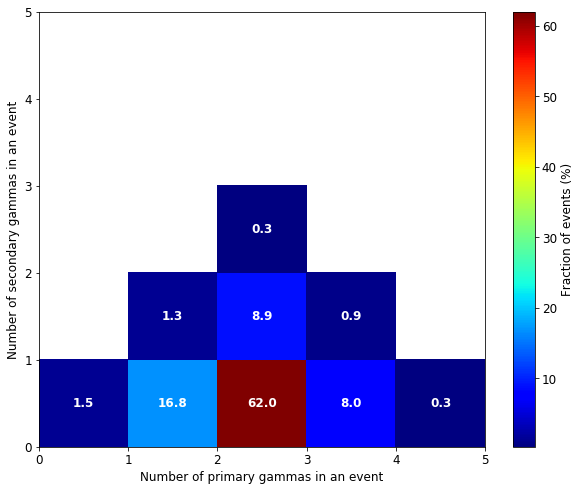

In [12]:
plt.figure()
z, y, x, _ = plt.hist2d(n_p, n_s, (np.arange(6), np.arange(6)), weights=w_t, cmin=1e-1, cmap="jet")

for i, xi in enumerate(shift(x)):
    for j, yj in enumerate(shift(y)):
        zij = z[i, j]
        plt.text(xi, yj, f"{zij:.1f}", color="w", ha="center", va="center", fontweight="bold")

plt.colorbar().set_label("Fraction of events (%)")
plt.xlabel("Number of primary gammas in an event")
plt.ylabel("Number of secondary gammas in an event")

In [13]:
e_p, e_s = map(np.concatenate, zip(*map(gamma_energy, mc.values())))

w_p = np.full(e_p.size, 100/e_p.size)
w_s = np.full(e_s.size, 100/e_s.size)

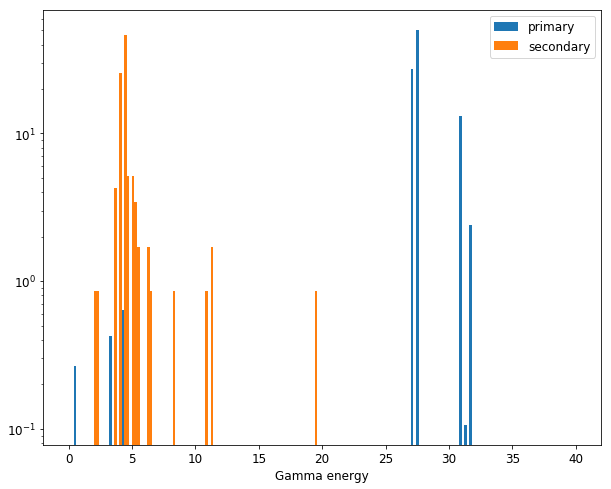

In [14]:
plt.figure()
data_p = plt.hist(e_p, np.linspace(0, 40, 201), weights=w_p, label="primary")
data_s = plt.hist(e_s, np.linspace(0, 40, 201), weights=w_s, label="secondary")
plt.yscale("log")
plt.xlabel("Gamma energy")
plt.legend()

In [15]:
print("====PRIMARY====")
print_nonempty(data_p)
print("====SECONDARY====")
print_nonempty(data_s)

====PRIMARY====
Energy: 0.500 ± 0.100  keV => 0.3
Energy: 3.300 ± 0.100  keV => 0.4
Energy: 3.700 ± 0.100  keV => 2.9
Energy: 4.100 ± 0.100  keV => 2.3
Energy: 4.300 ± 0.100  keV => 0.6
Energy: 4.500 ± 0.100  keV => 0.2
Energy: 27.100 ± 0.100  keV => 27.3
Energy: 27.500 ± 0.100  keV => 50.4
Energy: 30.900 ± 0.100  keV => 13.1
Energy: 31.300 ± 0.100  keV => 0.1
Energy: 31.700 ± 0.100  keV => 2.4
====SECONDARY====
Energy: 2.100 ± 0.100  keV => 0.9
Energy: 2.300 ± 0.100  keV => 0.9
Energy: 3.700 ± 0.100  keV => 4.3
Energy: 4.100 ± 0.100  keV => 25.6
Energy: 4.500 ± 0.100  keV => 46.2
Energy: 4.700 ± 0.100  keV => 5.1
Energy: 5.100 ± 0.100  keV => 5.1
Energy: 5.300 ± 0.100  keV => 3.4
Energy: 5.500 ± 0.100  keV => 1.7
Energy: 6.300 ± 0.100  keV => 1.7
Energy: 6.500 ± 0.100  keV => 0.9
Energy: 8.300 ± 0.100  keV => 0.9
Energy: 10.900 ± 0.100  keV => 0.9
Energy: 11.300 ± 0.100  keV => 1.7
Energy: 19.500 ± 0.100  keV => 0.9
